### MCMC likelihood 
In this example we demonstrate how our package can be applied in your likelihood pipeline for spectroscopic data: power spectrum, bispectrum, you name it. The example we showcase here takes the simplest linear Kaiser power spectrum for a model, however you can analogously apply it to any more advance model like EFTofLSS or TNS. To ensure efficiency and simplicity, we keep the cosmological parameters fixed and solely vary the linear bias $b_1$ and extension-specific parameters. This minimises the computational time and also helps avoid complex degeneracies with the scalar amplitude $A_s$ and expansion rate $h$. 

In [64]:
import MGrowth as mg
import numpy as np
import camb 
import getdist.plots
import matplotlib.pyplot as plt
from scipy.special import legendre
from scipy.integrate import simps
from numpy.linalg import inv
import emcee

Firts, we create DESI-like synthetic data for 3 power spectrum multipoles $$P_l(k) = \frac{2l+1}{2} \int_{-1}^1 \mathrm{d}\mu (b_1+f\mu^2)^2 P_\mathrm{CAMB}(k, z) \mathcal{P}_l(\mu)$$
and the corresponding covariance $$\mathrm{Cov}_{ll'}(kk') = \frac{2 \pi^2(2l+1)(2l'+1)}{V_\mathrm{eff} k^2 \Delta k} \int_{-1}^1 \mathrm{d}\mu \mathcal{P}_l(\mu) \mathcal{P}_{l'}(\mu) \left[  (b_1+f\mu^2)^2 P_\mathrm{CAMB}(k, z) + \frac{1}{\bar{n}} \right]^2 \delta_K(k-k')$$
with the following cosmological parmaters: $h = 0.6736$, $T_\mathrm{cmb} = 2.726$ K, $n_s  = 0.9649$, $\omega_c    = 0.12$, $\omega_b = 0.02237$, $\ln{\left(10^{10} ~A_s \right)} = 3.044$.
in 3 redshift bins: 


| sample | $z_\mathrm{eff}$ | $V_\mathrm{eff} \, [\mathrm{Gpc}^3/h^3]$ | $\bar{n} \, [h^3/\mathrm{Mpc}^3]$ | $b_1$ |
| --- | --- | --- | --- | --- |
| BGS  | $0.2$ | $1.8$ | $0.013$ | $1.135$ |
| LRGs | $0.8$ | $12$ | $3.2\times 10^{-4}$ | $2.56$ |
| ELGs | $1.2$ | $17$ | $3.7\times 10^{-4}$  | $1.51$ |



In [43]:
hubble = 0.6736
Tcmb   = 2.726
ns     = 0.9649
omch2    = 0.1200
ombh2    = 0.02237
logAs = 3.044


z1 = 0.2
z2 = 0.8
z3 = 1.2
V1 = 1.8*10**9 #Mpc3/h3
V2 = 12.*10**9 #Mpc3/h3
V3 = 17.*10**9 #Mpc3/h3
b1_z1 = 1.135
b1_z2 = 2.56
b1_z3 = 1.51
nbar1 = 0.013 #h3/Mpc3
nbar2 = 3.2e-4 #h3/Mpc3
nbar3 = 3.7e-4 #h3/Mpc3
zz = [z1, z2, z3]
aa = 1./(1.+np.array(zz[::-1]))


background ={'Omega_m': (omch2+ombh2)/hubble**2,
            'h' : hubble,
            'w0': -1.,
            'wa': 0.,
            'a_arr': [1.]}
cosmo_norm = mg.LCDM(background)
D_norm, _ = cosmo_norm.growth_parameters()
D_norm = D_norm[0]
background['a_arr'] = aa
cosmo = mg.LCDM(background)
Da, fa = cosmo.growth_parameters()
Dz, fz = Da[::-1], fa[::-1]


kmin_data = 0.006
kmax_data = 0.3
k_data = np.arange(kmin_data, kmax_data, kmin_data)
dk_data = kmin_data*np.ones(len(k_data))


p = camb.CAMBparams(WantTransfer=True, 
                    Want_CMB=False, Want_CMB_lensing=False, DoLensing=False, 
                    NonLinear="NonLinear_none",
                    WantTensors=False, WantVectors=False, WantCls=False, WantDerivedParameters=False,
                    want_zdrag=False, want_zstar=False)    
p.set_cosmology(H0=hubble*100, ombh2=ombh2, omch2=omch2, omk=0, mnu=0.)
p.set_initial_power(camb.initialpower.InitialPowerLaw(As=np.exp(logAs*1e-10), ns=ns))
p.set_dark_energy(w=-1.,wa=0.)
p.set_matter_power(redshifts=[0], kmax=10.0, nonlinear=False)
r = camb.get_results(p)
k_camb, z_lin, pkl_camb = r.get_matter_power_spectrum(minkh=1e-2, maxkh=3.0, npoints=512)
PL_z0 = np.interp(k_data, k_camb, pkl_camb[0])

mu_cov = np.linspace(-1, 1, 1001).reshape(1,1001)
def Pl_legendre(l1, P, b1, fg):
    br = (b1+fg*mu_cov**2)**2*P[:, None]
    C = (2.*l1+1)/2*simps(br * legendre(l1)(mu_cov), x=mu_cov, axis=1) 
    return C
def cov_legendre(l1, l2, P, b1, fg, nbar, Vs):
    Nk0 = dk_data/(2.*np.pi**2)*Vs
    br = ((b1+fg*mu_cov**2)**2*P[:, None] + 1./nbar)
    C = 1./(Nk0 * k_data**2)*(2.*l1+1)*(2.*l2+1)*simps(br**2 * legendre(l1)(mu_cov) * legendre(l2)(mu_cov), x=mu_cov, axis=1) 
    return C
def fill_cov(P, b1, fg, nbar, Vs):
    Cov = np.zeros((3*len(k_data), 3*len(k_data)))
    for i in range(len(k_data)):
        Cov[i][i] = cov_legendre(0, 0, P, b1, fg, nbar, Vs)[i]
        Cov[i+len(k_data)][i+len(k_data)] = cov_legendre(2, 2, P, b1, fg, nbar, Vs)[i]
        Cov[i+2*len(k_data)][i+2*len(k_data)] = cov_legendre(4, 4, P, b1, fg, nbar, Vs)[i]
        Cov[i][i+len(k_data)] = cov_legendre(0, 2, P, b1, fg, nbar, Vs)[i]
        Cov[i+len(k_data)][i] = cov_legendre(0, 2, P, b1, fg, nbar, Vs)[i]
        Cov[i][i+2*len(k_data)] = cov_legendre(0, 4, P, b1, fg, nbar, Vs)[i]
        Cov[i+2*len(k_data)][i] = cov_legendre(0, 4, P, b1, fg, nbar, Vs)[i]
        Cov[i+len(k_data)][i+2*len(k_data)] = cov_legendre(2, 4, P, b1, fg, nbar, Vs)[i]
        Cov[i+2*len(k_data)][i+len(k_data)] = cov_legendre(2, 4, P, b1, fg, nbar, Vs)[i]
    return Cov

DL, fL = Dz[0]/D_norm, fz[0]
PL = DL**2*PL_z0
Pell_z1_data = np.hstack((Pl_legendre(0, PL, b1_z1, fL), Pl_legendre(2, PL, b1_z1, fL), Pl_legendre(4, PL, b1_z1, fL)))
Cov_z1_data = fill_cov(PL, b1_z1, fL, nbar1, V1)

DL, fL = Dz[1]/D_norm, fz[1]
PL = DL**2*PL_z0
Pell_z2_data = np.hstack((Pl_legendre(0, PL, b1_z2, fL), Pl_legendre(2, PL, b1_z2, fL), Pl_legendre(4, PL, b1_z2, fL)))
Cov_z2_data = fill_cov(PL, b1_z2, fL, nbar2, V2)

DL, fL = Dz[2]/D_norm, fz[2]
PL = DL**2*PL_z0
Pell_z3_data = np.hstack((Pl_legendre(0, PL, b1_z3, fL), Pl_legendre(2, PL, b1_z3, fL), Pl_legendre(4, PL, b1_z3, fL)))
Cov_z3_data = fill_cov(PL, b1_z3, fL, nbar3, V3)


### Cut the data vectors

In [44]:
kmax = [0.10, 0.10, 0.10]
IdxP02 = (k_data <= kmax[0])
IdxP4 = (k_data <= kmax[2])
k_data_P02 = k_data[IdxP02]
k_data_P4 = k_data[IdxP4]
IdxTot = np.hstack((IdxP02, IdxP02, IdxP4)).astype(bool)


Pdata = np.array([Pell_z1_data[IdxTot], Pell_z2_data[IdxTot], Pell_z3_data[IdxTot]])
invCov = np.array([inv(Cov_z1_data[np.ix_(IdxTot, IdxTot)]), inv(Cov_z2_data[np.ix_(IdxTot, IdxTot)]), inv(Cov_z3_data[np.ix_(IdxTot, IdxTot)])])

### Plot the synthetic data

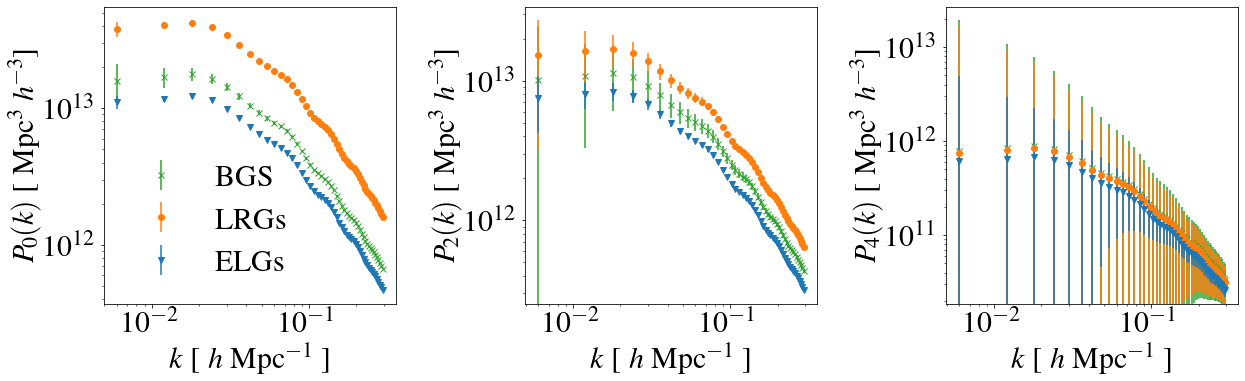

In [91]:
Nbin = len(k_data)
errors_z1 = np.sqrt(np.diag(Cov_z1_data))
errors_z2 = np.sqrt(np.diag(Cov_z2_data))
errors_z3 = np.sqrt(np.diag(Cov_z3_data))
P0 = [Pell_z1_data[:Nbin], Pell_z2_data[:Nbin], Pell_z3_data[:Nbin]]
P0_err = [errors_z1[:Nbin], errors_z2[:Nbin], errors_z3[:Nbin]]
P2 = [Pell_z1_data[Nbin:2*Nbin], Pell_z2_data[Nbin:2*Nbin], Pell_z3_data[Nbin:2*Nbin]]
P2_err = [errors_z1[Nbin:2*Nbin], errors_z2[Nbin:2*Nbin], errors_z3[Nbin:2*Nbin]]
P4 = [Pell_z1_data[2*Nbin:], Pell_z2_data[2*Nbin:], Pell_z3_data[2*Nbin:]]
P4_err = [errors_z1[2*Nbin:], errors_z2[2*Nbin:], errors_z3[2*Nbin:]]
colors=['tab:green', 'tab:orange', 'tab:blue']
fmts=['x', 'o', 'v']
labels=['BGS', 'LRGs', 'ELGs']
pell = ['$P_0(k)$', '$P_2(k)$', '$P_4(k)$']
fig, ax = plt.subplots(ncols=3, nrows = 1, figsize=(18, 6), sharex='col')
for i in range(3):
    ax[0].errorbar(k_data, P0[i], yerr = P0_err[i], color=colors[i], fmt=fmts[i], label=labels[i])
    ax[1].errorbar(k_data, P2[i], yerr = P2_err[i], color=colors[i], fmt=fmts[i])
    ax[2].errorbar(k_data, P4[i], yerr = P4_err[i], color=colors[i], fmt=fmts[i])
ax[0].legend(loc='lower left', frameon=False)
for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('$k$ [ $h$ Mpc$^{-1}$ ]')
    ax[i].set_ylabel(pell[i]+' [ Mpc$^3$ $h^{-3}$]')
plt.tight_layout()


### Define the model parameters and priors
As example here we take z-dependent Linder gamma, or redshift-dependent growth index parametrisation from arXiv:2304.07281 : $$\gamma(z) = \gamma_0 + \gamma_1\frac{z^2}{1+z}$$

In [77]:
MasterPriors = {
    'b1_z1':  {'type':'U', 'p0': b1_z1,  'p1': 0.6,     'p2': 4.,     'label': '$b^{z_1}_1$'},
    'b1_z2':  {'type':'U', 'p0': b1_z2,  'p1': 0.6,     'p2': 4.,     'label': '$b^{z_2}_1$'},
    'b1_z3':  {'type':'U', 'p0': b1_z3,  'p1': 0.6,     'p2': 4.,     'label': '$b^{z_3}_1$'},

    'gamma0': {'type':'U', 'p0': 0.55,  'p1': -1.,     'p2': 2.,     'label': '$\gamma_0$'},
    'gamma1': {'type':'U', 'p0': 0.,  'p1': -1.,     'p2': 2.,     'label': '$\gamma_1$'},
    'w0':     {'type':'U', 'p0': -1.,  'p1': -3.,     'p2': -0.3,     'label': '$w_0$'},
    'wa':     {'type':'U', 'p0': 0.,  'p1': -2.,     'p2': -2.,     'label': '$w_a$'},
    'A':      {'type':'U', 'p0': 0.,  'p1': -100.,     'p2': 100,     'label': '$A$'},
    'logfR0': {'type':'U', 'p0': -6.,  'p1': -5.,     'p2': -7,     'label': '$\log{\left(|f_{R0}|\right)}$'},
    'logOmrc':{'type':'U', 'p0': -2.,  'p1': -3.,     'p2': 2.,     'label': '$\log{\left(\Omega_\mathrm{rc}\right)}$'}
}
ModelPars = [ 'gamma0', 'gamma1', 'b1_z1', 'b1_z2', 'b1_z3']
ndim = len(ModelPars)
par_fid_array_cosmo = []
for p in ModelPars:
    par_fid_array_cosmo.append(MasterPriors[p]['p0'])

In [54]:
def lnprior(theta):
    gamma0, gamma1, b1_z1, b1_z2, b1_z3 = theta
    if (    gamma0>=MasterPriors['gamma0']['p1'] and gamma0<=MasterPriors['gamma0']['p2']  
        and gamma1>=MasterPriors['gamma1']['p1'] and gamma1<=MasterPriors['gamma1']['p2']  
        and b1_z1>=MasterPriors['b1_z1']['p1'] and b1_z1<=MasterPriors['b1_z1']['p2']  
        and b1_z2>=MasterPriors['b1_z2']['p1'] and b1_z2<=MasterPriors['b1_z2']['p2'] 
        and b1_z3>=MasterPriors['b1_z3']['p1'] and b1_z3<=MasterPriors['b1_z3']['p2'] 
	    ):
        return 0.0
    else:
        return -np.inf 

### Likelihood

In [59]:
cosmoMG = mg.Linder_gamma_a(background)

def lnlike(theta):
    gamma0, gamma1, b1_z1, b1_z2, b1_z3 = theta
    chi2_tot = 0
    b1_arr = [b1_z1, b1_z2, b1_z3]
    Da, fa = cosmoMG.growth_parameters(gamma0, gamma1)
    Dz_arr, fz_arr = Da[::-1], fa[::-1]
    for id in range(len(zz)):
        PL = (Dz_arr[id]/D_norm)**2*PL_z0
        b1 = b1_arr[id]
        fg = fz_arr[id]
        pk_theory = np.hstack((Pl_legendre(0, PL, b1, fg), Pl_legendre(2, PL, b1, fg), Pl_legendre(4, PL, b1, fg)))
        pk_td = pk_theory[IdxTot]-Pdata[id]
        invc = invCov[id]
        chi2 = np.einsum('i, ij, j', pk_td, invc, pk_td)
        chi2_tot += chi2
    return -0.5*chi2_tot

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = lnlike(theta)
    return lp + ll

### MCMC

In [61]:
nwalkers = 60
niter = 40000

par_norm = np.copy(par_fid_array_cosmo)
p0 = np.asarray([par_norm+5.e-2*(np.random.randn(ndim)) for i in range(nwalkers)])
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
# Track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(niter)
tau_all_params = np.empty([int(niter/100),ndim])
old_tau = np.inf

print("Running production...")
for sample in sampler.sample(p0, iterations=niter, progress=True, store=True):
    # Check convergence (compute tau) every 100 steps
    if sampler.iteration % 100: continue
    # Compute the autocorrelation time tau
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    tau_all_params[index] = tau
    index += 1
    # Check convergence, code stops if converged
    converged = np.all(tau * 50 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged or sampler.iteration == niter:
        burnin = int(5.0 * np.max(tau))
        thin  = int(0.2 * np.min(tau))
        break
    old_tau = tau



chain = sampler.get_chain(flat=True, discard=burnin, thin=thin)
logpr = sampler.get_log_prob(flat=True, discard=burnin, thin=thin)
np.savetxt("chain_Pell_kmax01_60w40k.txt", np.c_[chain, logpr])

Running production...


  6%|▋         | 2600/40000 [14:19<3:26:06,  3.02it/s]


### Plot posterior distribution

Removed no burn in


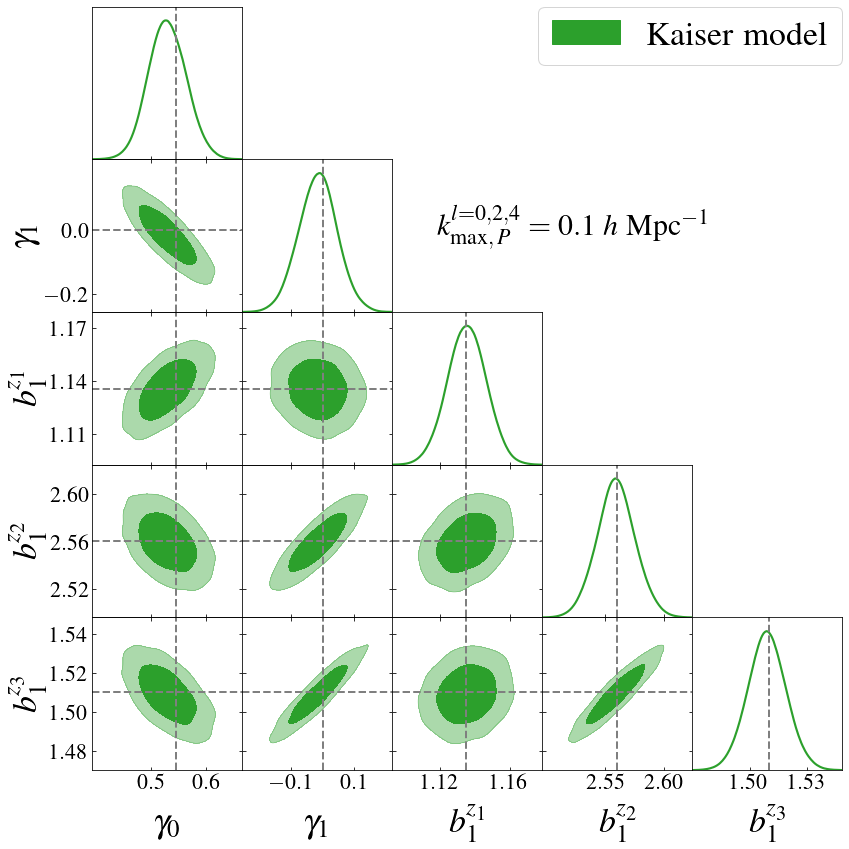

$\gamma_0$ = 0.529\pm 0.035 $\gamma_1$ = -0.015\pm 0.062


In [92]:
Pell = np.genfromtxt("chain_Pell_kmax01_60w40k.txt")
Fiducials = {'b1_z1':b1_z1, 'b1_z2': b1_z2, 'b1_z3': b1_z3, 'gamma0': 0.545, 'gamma1':0.}

Ranges = {}
for p in ModelPars:
    Ranges[p] = [MasterPriors[p]['p1'], MasterPriors[p]['p2']]

from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Times']})
g = getdist.plots.getSubplotPlotter(subplot_size=2.5)
plt.rcParams.update({'font.size':30})

Sample = []
Sample.append(getdist.MCSamples(samples = Pell[:,:len(ModelPars)], 
                                    names = [i for i in ModelPars],
                                    labels = [MasterPriors[p]['label']
                                                 for p in ModelPars], 
                                    ini = None, ranges=Ranges, label=r'Chain', settings={'smooth_scale_2D':0.35, 'smooth_scale_1D':0.35}))                                  
g.settings.legend_fontsize=36  
g.settings.axes_fontsize=24
g.settings.axes_labelsize=36
g.settings.linewidth=3   
colors = ['tab:green', 'tab:orange']
g.triangle_plot(Sample, filled=True, 
legend_labels = [
    'Kaiser model'], 
legend_loc = 'upper right',
contour_args = [{'filled':True, 'color': colors[0], 'ls': '-'}, {'filled':True, 'color': colors[1], 'ls': '-'}], 
line_args=[ {'color': colors[0], 'ls': '-'}, {'color': colors[1], 'ls': '-'}])
axtopright = g.subplots[1, 1]
axtopright.annotate('$k_{\mathrm{max}, \, P}^{l= 0, 2, 4} = 0.1$ $h$ Mpc$^{-1}$', (1.3, 0.5), xycoords='axes fraction', clip_on=False) 

if Fiducials != None:
    for i in range(len(ModelPars)):
        for j in range(i+1):
            ax = g.subplots[i,j]
            if i != j and ModelPars[i] in Fiducials and Fiducials[ModelPars[i]] != None:
                ax.axhline(Fiducials[ModelPars[i]],lw=2.,color='tab:gray', linestyle='--')
            if ModelPars[j] in Fiducials and Fiducials[ModelPars[j]] != None:
                ax.axvline(Fiducials[ModelPars[j]],lw=2.,color='tab:gray', linestyle='--')
          
plt.show()
#plt.savefig('Linder_gamma_z_posterior.pdf')  
print(Sample[0].getInlineLatex('gamma0',limit=1), Sample[0].getInlineLatex('gamma1',limit=1))